### Churn Prediction using PySurvival

#### Predicting when customers will churn 

In [16]:
# Importing modules
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pysurvival.datasets import Dataset
%pylab inline

# Reading the dataset
raw_dataset = Dataset('churn').load()
print("The raw_dataset has the following shape: {}.".format(raw_dataset.shape))
raw_dataset.head()

Populating the interactive namespace from numpy and matplotlib
The raw_dataset has the following shape: (2000, 14).


,product_data_storage,product_travel_expense,product_payroll,product_accounting,csat_score,articles_viewed,smartphone_notifications_viewed,marketing_emails_clicked,social_media_ads_viewed,minutes_customer_support,company_size,us_region,months_active,churned
0,2048,Free-Trial,Active,No,9,4,0,14,1,8.3,10-50,West North Central,3.0,1.0
1,2048,Free-Trial,Free-Trial,Active,9,4,2,12,1,0.0,100-250,South Atlantic,2.0,1.0
2,2048,Active,Active,Active,9,3,2,17,1,0.0,100-250,East South Central,7.0,0.0
3,500,Active,Free-Trial,No,10,0,0,14,0,0.0,50-100,East South Central,8.0,1.0
4,5120,Free-Trial,Active,Free-Trial,8,5,0,17,0,0.0,50-100,East North Central,7.0,0.0


#### categorical features to be encoded into one-hot vectors

- product_travel_expense
- product_payroll
- product_accounting
- us_region
- company_size

In [2]:
# Creating one-hot vectors
categories = ['product_travel_expense', 'product_payroll', 'product_accounting',
              'us_region', 'company_size']
dataset = pd.get_dummies(raw_dataset, columns=categories, drop_first=True)

# Creating the time and event columns
time_column = 'months_active'
event_column = 'churned'

# Extracting the features
features = np.setdiff1d(dataset.columns, [time_column, event_column] ).tolist()

#### Exploratory Analysis  - this section is skipped to focus on modelling

#### Check for Null/missing values and Duplicates

In [3]:
# Checking for null values
N_null = sum(dataset[features].isnull().sum())
print("The raw_dataset contains {} null values".format(N_null)) #0 null values

# Removing duplicates if they exist
N_dupli = sum(dataset.duplicated(keep='first'))
dataset = dataset.drop_duplicates(keep='first').reset_index(drop=True)
print("The raw_dataset contains {} duplicates".format(N_dupli))

# Number of samples in the dataset
N = dataset.shape[0]

The raw_dataset contains 0 null values
The raw_dataset contains 0 duplicates


In [4]:
raw_dataset.to_csv('churn.csv')

#### Checking for Correlations

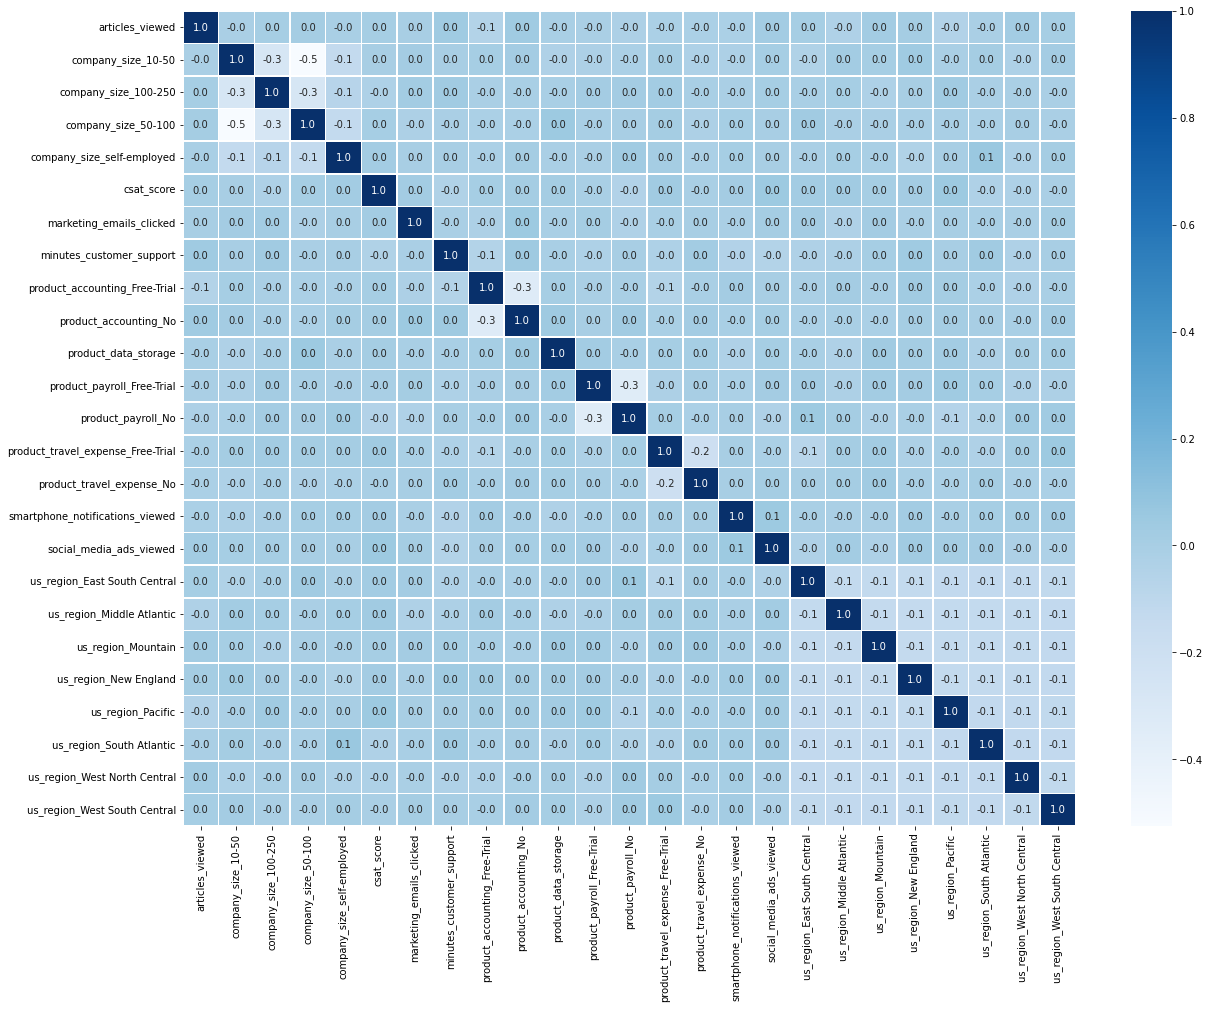

In [5]:
import seaborn as sns
corr = dataset[features].corr()
f, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(corr, cmap='Blues', annot=True, fmt='.1f', linewidths=.5, ax=ax)
plt.show()

### Modelling

#### Splitting the dataset into training and test sets

In [6]:
# Building training and testing sets
from sklearn.model_selection import train_test_split
index_train, index_test = train_test_split(range(N), test_size = 0.35)
data_train = dataset.loc[index_train].reset_index(drop = True)
data_test  = dataset.loc[index_test].reset_index(drop = True)

# Creating the X, T and E inputs
X_train, X_test = data_train[features], data_test[features]
T_train, T_test = data_train[time_column], data_test[time_column]
E_train, E_test = data_train[event_column], data_test[event_column]

### Fitting the model to the training set

In [7]:
from pysurvival.models.survival_forest import ConditionalSurvivalForestModel

# Fitting the model
csf = ConditionalSurvivalForestModel(num_trees=200)
csf.fit(X_train, T_train, E_train, max_features='sqrt',
        max_depth=5, min_node_size=20, alpha=0.05, minprop=0.1)

ConditionalSurvivalForestModel

In [8]:
# Computing variables importance
csf.variable_importance_table.head(5)

,feature,importance,pct_importance
0,csat_score,14.396751,0.212233
1,product_payroll_No,11.793993,0.173864
2,product_accounting_No,9.206830,0.135725
3,minutes_customer_support,7.838506,0.115553
4,product_payroll_Free-Trial,3.539412,0.052177


## Cross Validation

### C-index
- this is the model’s ability to correctly provide a reliable ranking of the survival times based on the individual risk scores
- when the C-index is close to 1, the model has an almost perfect discriminatory power 
- if it is close to 0.5, it has no ability to discriminate between low and high risk subjects

In [9]:
from pysurvival.utils.metrics import concordance_index
c_index = concordance_index(csf, X_test, T_test, E_test)
print('C-index: {:.2f}'.format(c_index)) #0.83

C-index: 0.83


#### Brier Score
- measures the average discrepancies between the status and the estimated probabilities at a given time
- the lower the score (usually below 0.25), the better the predictive performance
- To assess the overall error measure across multiple time points, the Integrated Brier Score (IBS) is usually computed as well

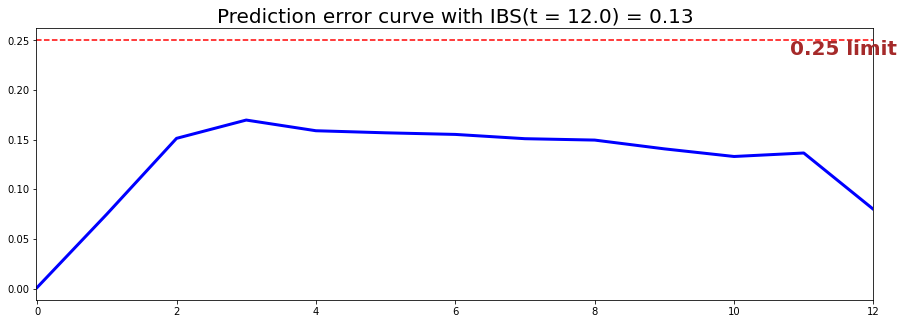

IBS: 0.13


In [10]:
from pysurvival.utils.display import integrated_brier_score
ibs = integrated_brier_score(csf, X_test, T_test, E_test, t_max=12,
    figure_size=(15,5))
print('IBS: {:.2f}'.format(ibs))

### Predictions

#### Overall predictions

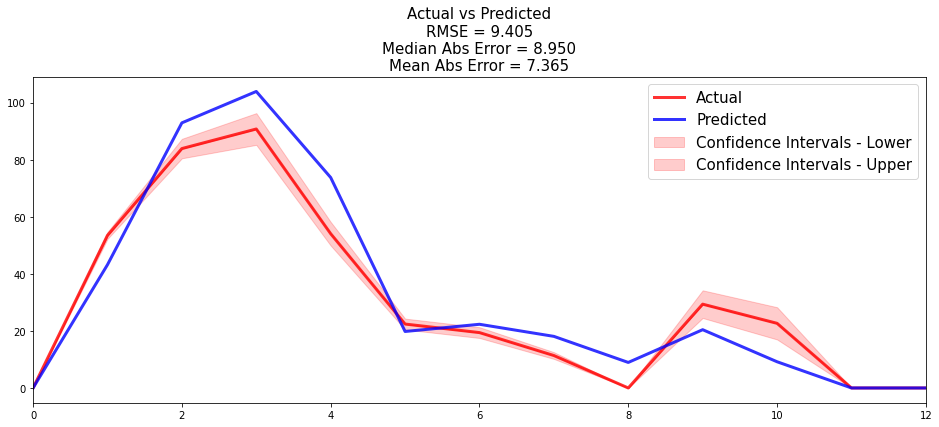

In [11]:
from pysurvival.utils.display import compare_to_actual
results = compare_to_actual(csf, X_test, T_test, E_test,
                            is_at_risk = False,  figure_size=(16, 6),
                            metrics = ['rmse', 'mean', 'median'])

#### Individual Predictions

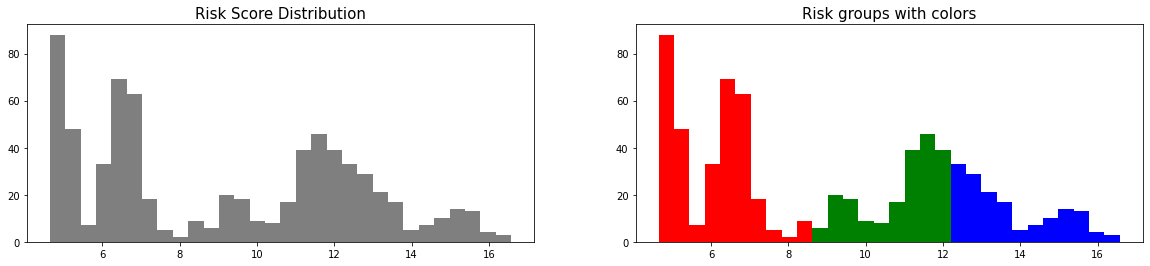

In [12]:
from pysurvival.utils.display import create_risk_groups

risk_groups = create_risk_groups(model=csf, X=X_test,
    use_log = False, num_bins=30, figure_size=(20, 4),
    low={'lower_bound':0, 'upper_bound':8.5, 'color':'red'},
    medium={'lower_bound':8.5, 'upper_bound':12.,'color':'green'},
    high={'lower_bound':12., 'upper_bound':25,  'color':'blue'}
    )

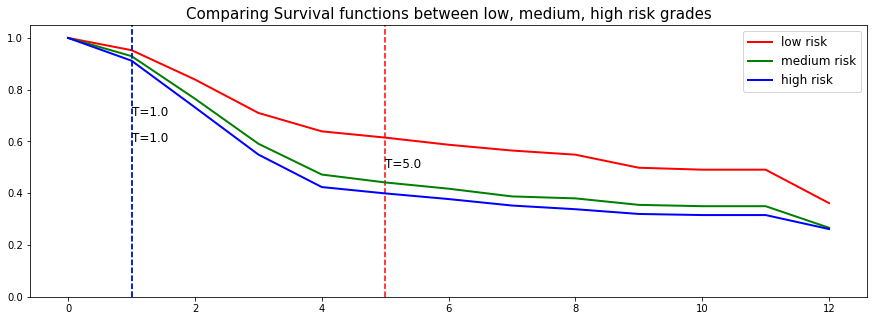

In [13]:
# Initializing the figure
fig, ax = plt.subplots(figsize=(15, 5))

# Selecting a random individual that experienced an event from each group
groups = []
for i, (label, (color, indexes)) in enumerate(risk_groups.items()) :

    # Selecting the individuals that belong to this group
    if len(indexes) == 0 :
        continue
    X = X_test.values[indexes, :]
    T = T_test.values[indexes]
    E = E_test.values[indexes]

    # Randomly extracting an individual that experienced an event
    choices = np.argwhere((E==1.)).flatten()
    if len(choices) == 0 :
        continue
    k = np.random.choice( choices, 1)[0]

    # Saving the time of event
    t = T[k]

    # Computing the Survival function for all times t
    survival = csf.predict_survival(X[k, :]).flatten()

    # Displaying the functions
    label_ = '{} risk'.format(label)
    plt.plot(csf.times, survival, color = color, label=label_, lw=2)
    groups.append(label)

    # Actual time
    plt.axvline(x=t, color=color, ls ='--')
    ax.annotate('T={:.1f}'.format(t), xy=(t, 0.5*(1.+0.2*i)),
        xytext=(t, 0.5*(1.+0.2*i)), fontsize=12)

# Show everything
groups_str = ', '.join(groups)
title = "Comparing Survival functions between {} risk grades".format(groups_str)
plt.legend(fontsize=12)
plt.title(title, fontsize=15)
plt.ylim(0, 1.05)
plt.show()

### Conclusion and Saving the model

In [17]:
from pysurvival.utils import save_model
save_model(csf, '/Users/johnstonkirimo/Projects/Survival Analysis - Tutorial/Data/churn_csf.zip')

Saving the model to disk as /Users/johnstonkirimo/Projects/Survival Analysis - Tutorial/Data/churn_csf.zip
